# Venues in Dehradun, India

## Table of Contents

<ul>
    <i><li>Introduction</li>
    <li>Data Collection from APIs</li>
    <li>Data Cleaning</li>
    <li>Methodolgy</li>
    <li>Analysis</li>
    <li>Results and Discussion</li>
     <li>Conclusion</li></i>
</ul>    
    

### Introduction 
<i>The aim of the project is to identify venues in Dehradun, India based on their rating and average prices. In this notebook, we will identify various venues in the city of Dehradun using Foursquare API and Zomato API, to help visitors select the restaurants that suit them the best.

Whenever a user is visiting a city they start searching for places to visit during their stay. They primarily look for places based on the venue ratings across all venues and the average prices such that the locations fits in their budget.

Here, we'll identify places that are fit for various individuals based on the information collected from the two APIs topped with Data Science. Once we have the plot with the venues, any firm/individual can launch an application using the same data and suggest users the necessary information.</i>

### Data Collection from APIs 
<i>To begin with, let's look at Dehradun on the Map using the folium library.

The data is fetched from two different APIs.
<ul>
    <li><b>Foursquare API</b>: The Foursquare API to fetch venues in Dehradun starting from the middle upto 10 Kilometers in each direction.</li>
    <li><b>Zomato API</b>: The Zomato API provides information about various venues including the complete address, user ratings, price for two people, price range and a lot more.</li>
</ul>
    
#### Dehradun
<i>Dehradun is composed of a number of sectors spread across a total area of 300 sq Km. There are many venues (especially restaurants, hotels and cafes) which can be explored.</i>


<font color=brown><i>Supply the lat, long values manually.</i></font>

In [4]:
TARGET_LATITUDE = 30.324317
TARGET_LONGITUDE = 78.041934
TARGET = 'Dehradun'
print('The geograpical coordinates of {} are {}, {}.'.format(TARGET, TARGET_LATITUDE, TARGET_LONGITUDE))

The geograpical coordinates of Dehradun are 30.324317, 78.041934.


In [2]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!pip install BeautifulSoup4
from bs4 import BeautifulSoup

import xml

!conda install -c conda-forge folium=0.5.0 --yes 
import folium # map rendering library

print('Libraries imported.')

Solving environment: ...working... done

# All requested packages already installed.

Solving environment: ...working... done

# All requested packages already installed.

Libraries imported.


<font color=brown><i>Let's use the folium library to create a complete map zoomed on Dehradun and plot a marker on the coordinatesidentified above. Providing relatively good look at the center point to be considering.</i></font>

In [5]:
target_location_map = folium.Map(location = [TARGET_LATITUDE, TARGET_LONGITUDE], zoom_start = 13)
folium.Marker([TARGET_LATITUDE, TARGET_LONGITUDE]).add_to(target_location_map)
target_location_map.save("C:/Anaconda/map.html")
target_location_map

#### Foursquare API
<font color=brown><i>Begin by fetching a total of all venues in Dehradun in a range of 10 Kilometers using the Foursquare API. The Foursquare API has the explore API argument which allows one to find venue recommendations within a given radius from the given coordinates.</i></font>

In [6]:
FOURSQUARE_CLIENT_ID = '3G0VFG5GEEN1CBAGVT35BDIUUTJXX1P45UBUILWNZI055DIW'
FOURSQUARE_CLIENT_SECRET = 'VQDEBG0F3WCPRG10ZPAQ2D3OF52XYPDD1HF0OIR0VV0GHJNA'
RADIUS = 10000 #10 Km
NO_OF_VENUES = 100
VERSION = '20200705' 

<font color=brown><i>Define the get_category_type method to get the correct category for each venue.</i></font>

In [7]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

<font color=brown><i>Call the API over and over till we get all venues from the API within the given distance. The maximum venues this API can fetch is 100, will fetch all venues by iteratively calling this API and increasing the offset each time.

Foursquare API requires client_id, and client_secret to function which can be accessed after creating a developer account.
set the radius to 10 Kilometers.
The version is a required parameter which defines the date on which we are browsing so that it retrieves the latest data.</i></font>

In [8]:
offset = 0
total_venues = 0
foursquare_venues = pd.DataFrame(columns = ['name', 'categories', 'lat', 'lng'])

while (True):
    url = ('https://api.foursquare.com/v2/venues/explore?client_id={}'
           '&client_secret={}&v={}&ll={},{}&radius={}&limit={}&offset={}').format(FOURSQUARE_CLIENT_ID, 
                                                                        FOURSQUARE_CLIENT_SECRET, 
                                                                        VERSION, 
                                                                        TARGET_LATITUDE, 
                                                                        TARGET_LONGITUDE, 
                                                                        RADIUS,
                                                                        NO_OF_VENUES,
                                                                        offset)
    result = requests.get(url).json()
    venues_fetched = len(result['response']['groups'][0]['items'])
    total_venues = total_venues + venues_fetched
    print("Total {} venues fetched within a total radius of {} Km".format(venues_fetched, RADIUS/1000))

    venues = result['response']['groups'][0]['items']
    venues = json_normalize(venues)

    # Filter the columns
    filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
    venues = venues.loc[:, filtered_columns]

    # Filter the category for each row
    venues['venue.categories'] = venues.apply(get_category_type, axis = 1)

    # Clean all column names
    venues.columns = [col.split(".")[-1] for col in venues.columns]
    foursquare_venues = pd.concat([foursquare_venues, venues], axis = 0, sort = False)
    
    if (venues_fetched < 100):
        break
    else:
        offset = offset + 100
        
foursquare_venues = foursquare_venues.reset_index(drop = True)
print("\nTotal {} venues fetched".format(total_venues))        

Total 37 venues fetched within a total radius of 10.0 Km

Total 37 venues fetched


C:\Anaconda\lib\site-packages\ipykernel_launcher.py:21: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead


#### Zomato API
<font color=brown><i>The Zomato API allows using its search API to search for any given venue based on certain search filters such as query, latitude, longitude and more. Zomato also requires a Zomato user key which can be accessed with a developer account.

Using the name, lat, and lng values of various venues fetched from Foursquare API to use the search API and get more information regarding each venue.
<ul>
    <li>The query will be the name of the venue.</li>
    <li>The start defines from what offset to begin with, keeping it to 0.</li>
    <li>The count defines the number of restaurants to be fetched. Having exact location coordinates,fetch only one per location.</li>
    <li>Supply the latitude and longitude values.</li>
    <li>Set the sorting criteria as real_distance so each time one get the venue one's searching based on location coordinates.</li>
</ul></i></font>

In [9]:
headers = {'user-key': 'e0b2ca9274a48aeb5fcd245ac037224a'}
venues_information = []

for index, row in foursquare_venues.iterrows():
    print("Fetching data for venue: {}".format(index + 1))
    venue = []
    url = ('https://developers.zomato.com/api/v2.1/search?q={}' + 
          '&start=0&count=1&lat={}&lon={}&sort=real_distance').format(row['name'], row['lat'], row['lng'])
    try:
        result = requests.get(url, headers = headers).json()
    except:
        print("There was an error...")
    try:
        
        if (len(result['restaurants']) > 0):
            venue.append(result['restaurants'][0]['restaurant']['name'])
            venue.append(result['restaurants'][0]['restaurant']['location']['latitude'])
            venue.append(result['restaurants'][0]['restaurant']['location']['longitude'])
            venue.append(result['restaurants'][0]['restaurant']['average_cost_for_two'])
            venue.append(result['restaurants'][0]['restaurant']['price_range'])
            venue.append(result['restaurants'][0]['restaurant']['user_rating']['aggregate_rating'])
            venue.append(result['restaurants'][0]['restaurant']['location']['address'])
            venues_information.append(venue)
        else:
            venues_information.append(np.zeros(6))
    except:
        pass
        
zomato_venues = pd.DataFrame(venues_information, 
                                  columns = ['venue', 'latitude', 
                                             'longitude', 'price_for_two', 
                                             'price_range', 'rating', 'address'])

Fetching data for venue: 1
Fetching data for venue: 2
Fetching data for venue: 3
Fetching data for venue: 4
Fetching data for venue: 5
Fetching data for venue: 6
Fetching data for venue: 7
Fetching data for venue: 8
Fetching data for venue: 9
Fetching data for venue: 10
Fetching data for venue: 11
Fetching data for venue: 12
Fetching data for venue: 13
Fetching data for venue: 14
Fetching data for venue: 15
Fetching data for venue: 16
Fetching data for venue: 17
Fetching data for venue: 18
Fetching data for venue: 19
Fetching data for venue: 20
Fetching data for venue: 21
Fetching data for venue: 22
Fetching data for venue: 23
Fetching data for venue: 24
Fetching data for venue: 25
Fetching data for venue: 26
Fetching data for venue: 27
Fetching data for venue: 28
Fetching data for venue: 29
Fetching data for venue: 30
Fetching data for venue: 31
Fetching data for venue: 32
Fetching data for venue: 33
Fetching data for venue: 34
Fetching data for venue: 35
Fetching data for venue: 36
F

In [10]:
zomato_venues = pd.DataFrame(venues_information, 
                                  columns = ['venue', 'latitude', 
                                             'longitude', 'price_for_two', 
                                             'price_range', 'rating', 'address'])

### Data Cleaning 
<font color=brown><i>The data from multiple resources might not always align. Thus, it is important to combine the data retrieved from multiple resources properly.

First plot the two data points on the map. Then try to combine data points that have their latitude and longitude values very close to one another. From the remaining selected venues, inspect the venues to ensure that any remaining mismatched venues are also removed from the final dataset of venues before any analysis.

First plot the Foursquare data on the map.</i></font>

In [11]:
target_location_map = folium.Map(location = [TARGET_LATITUDE, TARGET_LONGITUDE], zoom_start = 13)

for name, latitude, longitude in zip(foursquare_venues['name'], foursquare_venues['lat'], foursquare_venues['lng']):
    label = '{}'.format(name)
    label = folium.Popup(label, parse_html = True)
    folium.CircleMarker(
        [latitude, longitude],
        radius = 5,
        popup = label,
        color = 'indigo',
        fill = True,
        fill_color = '#6a31cc',
        fill_opacity = 0.7,
        parse_html = False).add_to(target_location_map)  

target_location_map.save("C:/Anaconda/map.html")
target_location_map

<font color=brown><i>From the map, It is infered that there are clusters of venues around <b>Rajpur Road</b>.

Plot the Zomato data on the map.</i></font>

In [12]:
target_location_map = folium.Map(location = [TARGET_LATITUDE, TARGET_LONGITUDE], zoom_start = 13)

for venue, address, latitude, longitude in zip(zomato_venues['venue'], zomato_venues['address'], 
                                               zomato_venues['latitude'], zomato_venues['longitude']):
    UPDATED_LG = float(longitude)
    UPDATED_LT = float(latitude)
    label = '{}, {}'.format(name, address)
    label = folium.Popup(label, parse_html = True)
    folium.CircleMarker(
        [UPDATED_LT, UPDATED_LG],
        radius = 5,
        popup = label,
        color = 'red',
        fill = True,
        fill_color = '#cc3535',
        fill_opacity = 0.7,
        parse_html = False).add_to(target_location_map)  

target_location_map.save("C:/Anaconda/map.html")
target_location_map

<font color=brown><i>There are many venues identified by both Foursquare and Zomato. There is a lot of overlapping between the two near Rajpur Road. However, there are others where the data does not match just like the markers at <b>Kanwali Road and ISBT road</b> on the second map.

To combine the two datasets,check that the latitude and longitude values of each corresponding venue match. Thus, round both the latitude and longitude values upto 4 decimal places. Then, calculate the difference between the corresponding latitude and longitude values and check if the difference is less than 0.0004 which should ideally mean that the two locations are same.</i></font>

In [15]:
foursquare_venues['lat'] = foursquare_venues['lat'].apply(lambda lat: round(float(lat), 4))
foursquare_venues['lng'] = foursquare_venues['lng'].apply(lambda lng: round(float(lng), 4))
zomato_venues['latitude'] = zomato_venues['latitude'].apply(lambda lat: round(float(lat), 4))
zomato_venues['longitude'] = zomato_venues['longitude'].apply(lambda lng: round(float(lng), 4))

In [16]:
dataset = pd.concat([foursquare_venues, zomato_venues], axis = 1)
#dataset
#dataset['lat_diff'] = dataset['latitude'] - dataset['lat']
#dataset['lng_diff'] = dataset['longitude'] - dataset['lng']

In [17]:
#selected_venues = dataset[(abs(dataset['lat_diff']) <= 0.0004) & (abs(dataset['lng_diff']) <= 0.0004)].reset_index(drop = True)
selected_venues=dataset
selected_venues

,name,categories,lat,lng,venue,latitude,longitude,price_for_two,price_range,rating,address
0,The Buffet,Fast Food Restaurant,30.3270,78.0452,Ambrosia,30.3279,78.0453,1200.0,4.0,3.6,"21, Centre Point, Near Astley Hall, Rajpur Roa..."
1,Anandam,Indian Restaurant,30.3353,78.0532,Anandam,30.3351,78.0533,650.0,3.0,4.3,"69, Krishna Tower, Rajpur Road, Hathibarkala S..."
2,KFC,Fast Food Restaurant,30.3338,78.0515,KFC,30.3336,78.0516,450.0,2.0,4.3,"65A, Rajpur Road, Hathibarkala Salwala, Dehradun"
3,Ellora Bakers And Confectioners,Bakery,30.3287,78.0464,Ellora Homeaids,30.3288,78.0463,300.0,2.0,3.7,"25, Rajpur Road, Chukkuwala, Dehradun"
4,Barista,Café,30.3093,78.0542,Barista,30.3269,78.0449,500.0,3.0,3.7,"15 A, English Book Depot, Rajpur Road, Chukkuw..."
5,Sunburn Bistro,Tea Room,30.3327,78.0540,Bottoms Up Bistro,30.3600,78.0679,1000.0,4.0,3.3,"2nd Floor, Jakhan Tower, Above Corporation Ban..."
6,Dehradun,Scenic Lookout,30.3383,78.0683,Yaarana,30.3391,78.0706,150.0,1.0,0,"Lane 3, Ekta Vihar, Sahastradhara Road, Chiron..."
7,Forest Research Institute,Nature Preserve,30.3331,77.9953,Barbeque Planet,30.3291,78.0115,1000.0,4.0,3.4,"Chandan Palace, Opposite Wadia Institute, GMS ..."
8,Black Pepper,Indian Restaurant,30.3283,78.0465,Black Pepper Restaurant,30.3279,78.0464,800.0,3.0,4.3,"3, First and Second Floor, Astley Hall, Rajpur..."
9,Paltan Bazaar,Flea Market,30.3231,78.0406,31 Flavours,30.3230,78.0406,350.0,2.0,3.6,"39, Paltan Bazar Road, Paltan Bazaar, Dehradun"


<font color=brown><i>Also get the average price per person by dividing the column price_for_two by 2 and removing this column from the dataset along with other unnecessary columns.</i></font>

In [18]:
selected_venues['average_price'] = selected_venues['price_for_two']/2
selected_venues = selected_venues.drop(columns = ['name', 'lat', 'lng', 'price_for_two'])
selected_venues.head()

,categories,venue,latitude,longitude,price_range,rating,address,average_price
0,Fast Food Restaurant,Ambrosia,30.3279,78.0453,4.0,3.6,"21, Centre Point, Near Astley Hall, Rajpur Roa...",600.0
1,Indian Restaurant,Anandam,30.3351,78.0533,3.0,4.3,"69, Krishna Tower, Rajpur Road, Hathibarkala S...",325.0
2,Fast Food Restaurant,KFC,30.3336,78.0516,2.0,4.3,"65A, Rajpur Road, Hathibarkala Salwala, Dehradun",225.0
3,Bakery,Ellora Homeaids,30.3288,78.0463,2.0,3.7,"25, Rajpur Road, Chukkuwala, Dehradun",150.0
4,Café,Barista,30.3269,78.0449,3.0,3.7,"15 A, English Book Depot, Rajpur Road, Chukkuw...",250.0


<font color=brown><i>Drop the venues which have 0.0 rating as it's significant or not been rated yet.</i></font>

In [19]:
selected_venues = selected_venues[selected_venues['rating'] != 0.0]
print("Total venues available: {}".format(selected_venues.shape[0]))

Total venues available: 29


### Methodology 
<font color=brown><i>This project aims at identifying the venues in Dehradun based on their rating and average costs. This would enable any visitor to identify the venues he/she wants to visit based on their rating and cost preference.

As a first step, <b>the data from two APIs (Foursquare and Zomato)is retrieved</b>. Extract venue information from the center of Dehradun, upto a distance of 10 Km. The latitude and longitude values are then used to fetch venue rating and price from Zomato.

Secondly, <b>the data retrieved from the two APIs on the map is explored</b> and identified the top category types. <b>The data from the two sources is carefully combined</b> based on the name, latitude and longitude values from the two sources. The final dataset would include the rating and price values for each venue.

Next, <b>Analyse the data</b> that is created based on the ratings and price of each venue. <b>Identify places where cluster of venues are located</b> so that any visitor can go to one place and enjoy the option to choose amongst many venue options. Also explore <b>areas that are high rated and those that are low rated</b> while also plotting the map of high and low priced venues. Lastly, <b>cluster the venues using partitioning</b> based on the available information of each venue. This will allow one to clearly identify which venues can be recommended and with what characteristics.

Finally, discuss and conclude which venues to be explored based on visitor requirement of rating and cost.


##### Analysis 
The complete dataset is now in its final form.
    <b>Inspect these venues based on their rating</b>. The rating of a venue are based on user reviews and belongs to a range from 1 to 5. Also <b>analyse the venues based on their price per person as well as the price range</b>.


###### Categories
There are various types of venues in the final dataset. Take a look at the venues and check which are the majority venue categories in the list.</i></font>

<BarContainer object of 22 artists>

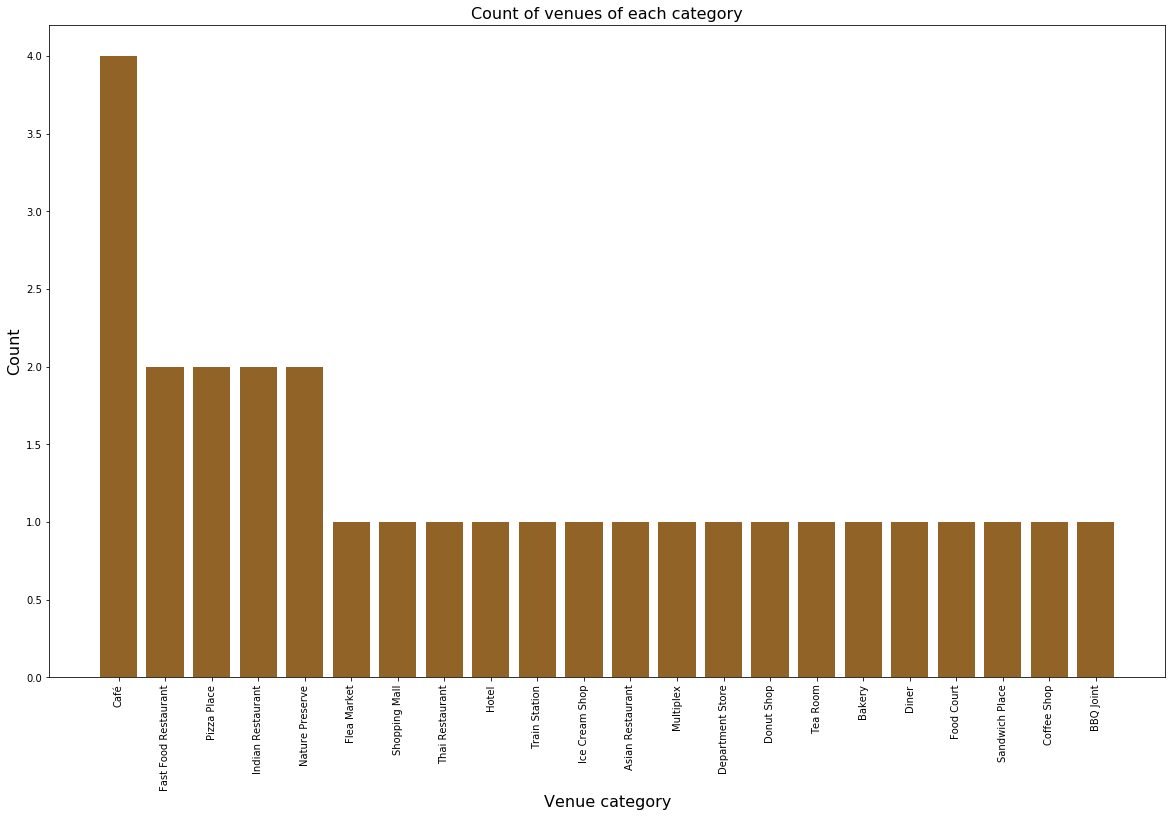

In [20]:
import matplotlib.pyplot as plt
venue_distribution = selected_venues['categories'].value_counts()
colors = cm.rainbow(np.linspace(0, 1, len(venue_distribution.index)))
plt.figure(figsize = (20, 12))
plt.xticks(rotation = 90)
plt.xlabel("Venue category", fontsize = 16)
plt.ylabel("Count", fontsize = 16)
plt.title("Count of venues of each category", fontsize = 16)
plt.bar(venue_distribution.index, venue_distribution.values, color = '#916327')

<font color=brown><i>The majority venues are <b>Cafe, Fast Food Restaurants and Indian Restaurant</b>. 
##### Rating
Rating of a venue is an important factor on which a visitor decides whether it is worth visiting the place. To cater to this, see what is the average rating for all the venues in the city. Next, plot the venues on the map and color code them.

First identify the various rating values and plot them as a bar plot with their counts to see the most common rating.</i></font>

Text(0.5, 1.0, 'Count of venues with given rating')

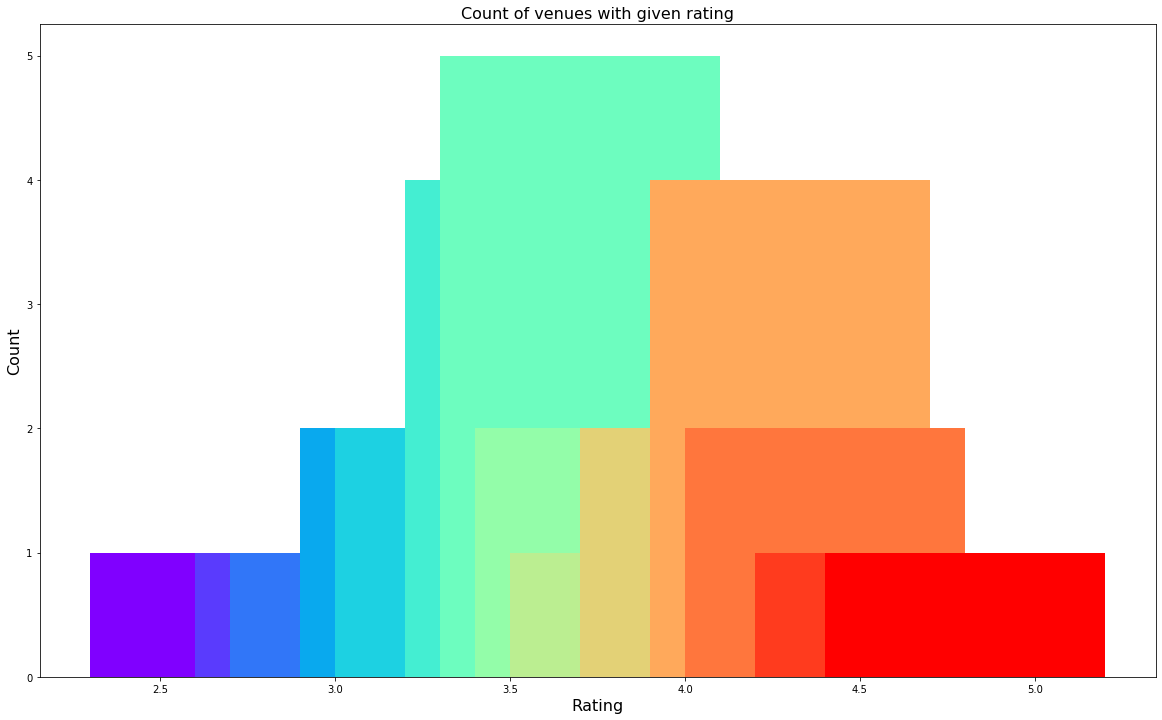

In [21]:
selected_venues['rating'] = selected_venues['rating'].astype(float)
rating = selected_venues['rating'].value_counts().sort_index()
plt.figure(figsize = (20, 12))
plt.bar(rating.index, rating.values, color = cm.rainbow(np.linspace(0, 1, len(rating.index))))
plt.xlabel("Rating", fontsize = 16)
plt.ylabel("Count", fontsize = 16)
plt.title("Count of venues with given rating", fontsize = 16)

<font color=brown><i>From the plot above, majority venues have their rating close to 4.

Let's create bins for various ratings and plot them in different colors on the map. The ratings will be divided between 4 bins:
<ul>
    <li>1 to 2</li>
    <li>2 to 3</li>
    <li>3 to 4</li>
    <li>4 to 5</li>
    </ul>    
</i></font>

In [22]:
bins = [1.0, 2.0, 3.0, 4.0, 5.0]
labels = ['Low', 'Okay', 'Good', 'Very good']
selected_venues['rating_bin'] = pd.cut(selected_venues['rating'].astype(float), bins = bins, labels = labels, include_lowest = True)

In [25]:
color_map = {'Low': 'red', 'Okay': 'orange', 'Good': 'green', 'Very good': 'blue'}

target_location_map = folium.Map(location = [TARGET_LATITUDE, TARGET_LONGITUDE], zoom_start = 12)

for name, address, latitude, longitude, rating_bin in zip(selected_venues['venue'], 
                                                          selected_venues['address'], 
                                                          selected_venues['latitude'], 
                                                          selected_venues['longitude'], 
                                                          selected_venues['rating_bin']):
    label = '{}, {}'.format(name, address)
    label = folium.Popup(label, parse_html = True)
    folium.Marker(
        [latitude, longitude],
        icon = folium.Icon(color = color_map[rating_bin]),
        popup = label).add_to(target_location_map)   

target_location_map.save("C:/Anaconda/maps.html")
target_location_map

<font color=brown><i>The map has the location of all the venues. It appears that many venues are located around <b>Rajpur Road, Chakrata Road and ISBT road</b>  with rating above 3. A visitor should definitely check out these areas.

##### Price
Take a look at the venues based on the price values. Having two price features for our venues, one is average_price which defines the average cost for one person and the other is price_range which determines the price range as defined by Zomato.

First explore the average_price using a scatter plot between the price and the count of venues with that average price. Size the points based on the price to highlight their price.</i></font>

Text(0.5, 1.0, 'Count of venues with given average price')

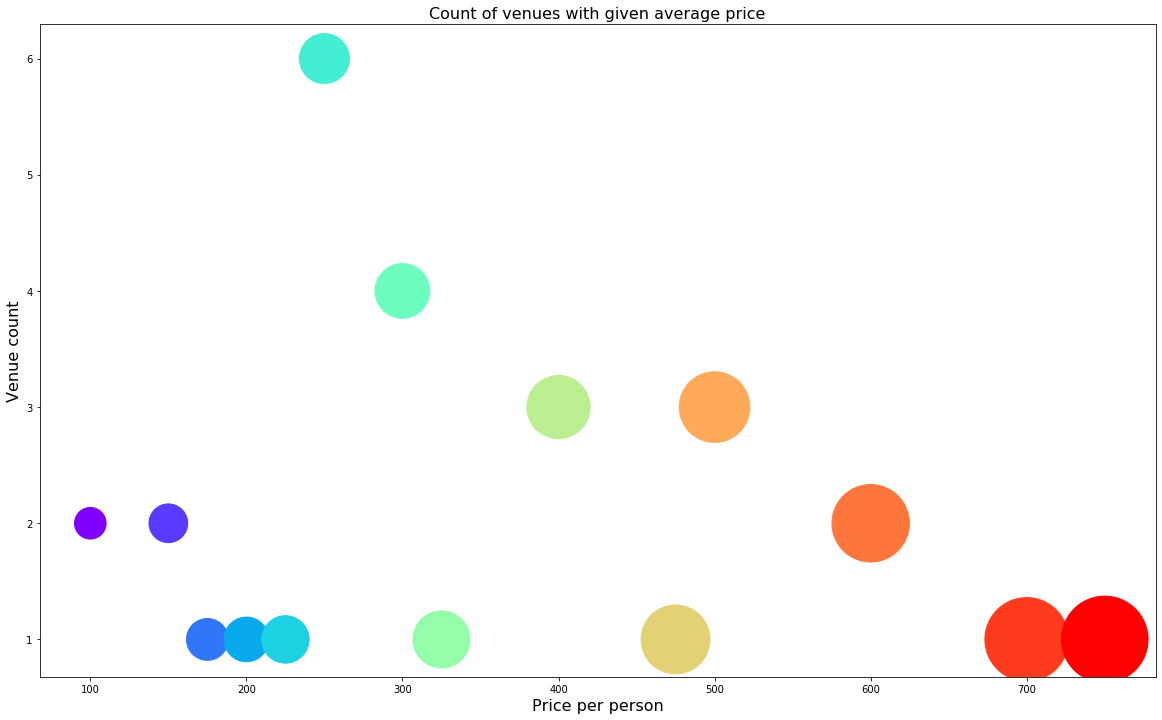

In [26]:
average_prices = selected_venues['average_price'].value_counts().sort_index()
plt.figure(figsize = (20, 12))
plt.scatter(average_prices.index, 
            average_prices.values, 
            s = average_prices.index*10, 
            c = cm.rainbow(np.linspace(0, 1, len(average_prices.index))))
plt.xlabel("Price per person", fontsize = 16)
plt.ylabel("Venue count", fontsize = 16)
plt.title("Count of venues with given average price", fontsize = 16)

<font color=brown><i>From the plot above, a large number of venues have an average price between <b>Rs 250 and Rs 500</b>.

Users might also be interested in going to a place that fits in their budget. Let's use the price_range column to plot the venues on a map and represent the venues with lower price in green and move towards red as the price increases.</i></font>

In [44]:
color_map = {'1.0': 'green', '2.0': 'darkgreen', '3.0': 'orange', '4.0': 'red'} #ordered as low to high price range

target_location_map = folium.Map(location = [TARGET_LATITUDE, TARGET_LONGITUDE], zoom_start = 12)

for name, address, latitude, longitude, price_range in zip(selected_venues['venue'], 
                                                           selected_venues['address'], 
                                                           selected_venues['latitude'], 
                                                           selected_venues['longitude'], 
                                                           selected_venues['price_range'].astype(str)):
    label = '{}, {}'.format(name, address)
    label = folium.Popup(label, parse_html = True)
    folium.Marker(
        [latitude, longitude],
        icon = folium.Icon(color = color_map[price_range]),
        popup = label).add_to(target_location_map)  

target_location_map.save("C:/Anaconda/maps.html")
target_location_map

<font color=brown><i>The venues near <b>Clock Tower, Chakrata Road and ISBT Road</b> are primarily lower priced.
The venues at <b>upper Rajpur Road</b> has steep prices.
    
##### Clustering
cluster all these venues based on their price range, location and more to identify similar venues and the relationship amongst them. Let's cluster the venues into two separate groups.</i></font>

In [56]:
NO_OF_CLUSTERS = 2

clustering = selected_venues.drop(['venue', 'address', 'rating_bin', 'categories'], 1)
kMeans = KMeans(n_clusters = NO_OF_CLUSTERS, random_state = 0).fit(clustering)
#selected_venues.insert(0, 'cluster_labels', kMeans.labels_)
selected_venues.head(36)

,cluster_labels,categories,venue,latitude,longitude,price_range,rating,address,average_price,rating_bin
0,0,Fast Food Restaurant,Ambrosia,30.3279,78.0453,4.0,3.6,"21, Centre Point, Near Astley Hall, Rajpur Roa...",600.0,Good
1,1,Indian Restaurant,Anandam,30.3351,78.0533,3.0,4.3,"69, Krishna Tower, Rajpur Road, Hathibarkala S...",325.0,Very good
2,1,Fast Food Restaurant,KFC,30.3336,78.0516,2.0,4.3,"65A, Rajpur Road, Hathibarkala Salwala, Dehradun",225.0,Very good
3,1,Bakery,Ellora Homeaids,30.3288,78.0463,2.0,3.7,"25, Rajpur Road, Chukkuwala, Dehradun",150.0,Good
4,1,Café,Barista,30.3269,78.0449,3.0,3.7,"15 A, English Book Depot, Rajpur Road, Chukkuw...",250.0,Good
5,0,Tea Room,Bottoms Up Bistro,30.3600,78.0679,4.0,3.3,"2nd Floor, Jakhan Tower, Above Corporation Ban...",500.0,Good
7,0,Nature Preserve,Barbeque Planet,30.3291,78.0115,4.0,3.4,"Chandan Palace, Opposite Wadia Institute, GMS ...",500.0,Good
8,0,Indian Restaurant,Black Pepper Restaurant,30.3279,78.0464,3.0,4.3,"3, First and Second Floor, Astley Hall, Rajpur...",400.0,Very good
9,1,Flea Market,31 Flavours,30.3230,78.0406,2.0,3.6,"39, Paltan Bazar Road, Paltan Bazaar, Dehradun",175.0,Good
11,0,Thai Restaurant,Kalsang Friends Corner,30.3469,78.0625,3.0,4.6,"opp - OSHO ,88/A, Rajpur Road, Dehradun",400.0,Very good


In [73]:
target_location_map = folium.Map(location = [TARGET_LATITUDE, TARGET_LONGITUDE], zoom_start = 13)
color_map = { 0: '#199c8f', 1: '#8614a3'}

# add venues to the map
markers_colors = []
for venue, address, cluster, latitude, longitude in zip(selected_venues['venue'], 
                                                        selected_venues['address'], 
                                                        selected_venues['cluster_labels'], 
                                                        selected_venues['latitude'], 
                                                        selected_venues['longitude']):
    label = folium.Popup(str(cluster) + ',' + str(venue) + ', ' + str(address), parse_html = True)
    folium.CircleMarker(
        [latitude, longitude],
        radius = 5,
        popup = label,
        color = color_map[cluster],
        fill = True,
        fill_color = color_map[cluster],
        fill_opacity = 0.7).add_to(target_location_map)

# add cluster centers to the map
for index, cluster in enumerate(kMeans.cluster_centers_):
    latitude = cluster[0]
    longitude = cluster[1]
    label = folium.Popup("Cluster: " + str(index), parse_html = True)
    folium.CircleMarker(
        [latitude, longitude],
        radius = 10,
        popup = label,
        color = color_map[index],
        fill = True,
        fill_color = color_map[index],
        fill_opacity = 0.7).add_to(target_location_map)

target_location_map.save("C:/Anaconda/maps.html")
target_location_map

<font color=brown><i>The two clusters from the map:

The first(0) cluster is very sparsely spread and has very less venues(mostly at <b>upper Rajpur Road</b>).
The second(1) cluster is at the central part of the city(Supplied lat, long <b>@Clock tower</b>) and includes the majority venues.
    
Check the venues of the two clusters.</i></font>

In [75]:
result = selected_venues[selected_venues['cluster_labels'] == 0]
print("Cluster 0")
result.head(11).reset_index(drop = True)

Cluster 0


,cluster_labels,categories,venue,latitude,longitude,price_range,rating,address,average_price,rating_bin
0,0,Fast Food Restaurant,Ambrosia,30.3279,78.0453,4.0,3.6,"21, Centre Point, Near Astley Hall, Rajpur Roa...",600.0,Good
1,0,Tea Room,Bottoms Up Bistro,30.3600,78.0679,4.0,3.3,"2nd Floor, Jakhan Tower, Above Corporation Ban...",500.0,Good
2,0,Nature Preserve,Barbeque Planet,30.3291,78.0115,4.0,3.4,"Chandan Palace, Opposite Wadia Institute, GMS ...",500.0,Good
3,0,Indian Restaurant,Black Pepper Restaurant,30.3279,78.0464,3.0,4.3,"3, First and Second Floor, Astley Hall, Rajpur...",400.0,Very good
4,0,Thai Restaurant,Kalsang Friends Corner,30.3469,78.0625,3.0,4.6,"opp - OSHO ,88/A, Rajpur Road, Dehradun",400.0,Very good
5,0,BBQ Joint,Grille Restaurant,30.3635,78.0694,4.0,4.1,"4th Floor, Axiom Mall, 152 Rajpur Road, Jakhan...",700.0,Very good
6,0,Asian Restaurant,Orchard,30.3892,78.0948,3.0,4.8,"3 D, Dak Patti, Near Mdda Park, Rajpur, Dehradun",400.0,Very good
7,0,Hotel,The Terrace - Four Points by Sheraton Dehradun,30.3654,78.0702,4.0,3.1,"152/4, Rajpur Road, Jakhan, Dehradun",750.0,Good
8,0,Café,Cafe Lychee Tree,30.3009,78.0560,3.0,3.6,"G-24/5, Nehru Colony, Near Idbi Bank, Dharampu...",475.0,Good
9,0,Train Station,Spice Restaurant - Hotel Galaxy,30.3139,78.0355,4.0,3.3,"Hotel Galaxy, 11/5, Tyagi Road, Race Course, D...",500.0,Good


In [76]:
print("These venues for cluster 0 have mean price range of {:.02f} and rating spread around {:.02f}".
      format(result['price_range'].mean(), result['rating'].astype(float).mean()))

These venues for cluster 0 have mean price range of 3.64 and rating spread around 3.79


In [78]:
result = selected_venues[selected_venues['cluster_labels'] == 1]
print("Cluster 1")
result.head(25).reset_index(drop = True)

Cluster 1


,cluster_labels,categories,venue,latitude,longitude,price_range,rating,address,average_price,rating_bin
0,1,Indian Restaurant,Anandam,30.3351,78.0533,3.0,4.3,"69, Krishna Tower, Rajpur Road, Hathibarkala S...",325.0,Very good
1,1,Fast Food Restaurant,KFC,30.3336,78.0516,2.0,4.3,"65A, Rajpur Road, Hathibarkala Salwala, Dehradun",225.0,Very good
2,1,Bakery,Ellora Homeaids,30.3288,78.0463,2.0,3.7,"25, Rajpur Road, Chukkuwala, Dehradun",150.0,Good
3,1,Café,Barista,30.3269,78.0449,3.0,3.7,"15 A, English Book Depot, Rajpur Road, Chukkuw...",250.0,Good
4,1,Flea Market,31 Flavours,30.3230,78.0406,2.0,3.6,"39, Paltan Bazar Road, Paltan Bazaar, Dehradun",175.0,Good
5,1,Food Court,Kumar Sweet Shop,30.3253,78.0427,2.0,4.4,"R1, Rajpur Road, Chukkuwala, Dehradun",200.0,Very good
6,1,Pizza Place,Pizza Hut,30.3425,78.0608,3.0,3.7,"542, Rajpur Road, Dehradun Nagar Nigam, Salwal...",300.0,Good
7,1,Pizza Place,Pizza Hut,30.3221,78.0033,3.0,3.9,"C1/101, Indra Nagar, Dehradun Nagar Nigam, Bal...",300.0,Good
8,1,Ice Cream Shop,Baskin Robbins,30.3289,78.0461,1.0,4.3,"9, Astley Hall, Rajpur Road, Karanpur, Dehradun",100.0,Very good
9,1,Coffee Shop,Cafe Coffee Day,30.3224,78.0430,3.0,3.7,"Darshan Lal Chowk, Near Clock Tower, Race Cour...",250.0,Good


In [79]:
print("These venues for cluster 1 have mean price range of {:.02f} and rating spread around {:.02f}".
      format(result['price_range'].mean(), result['rating'].astype(float).mean()))

These venues for cluster 1 have mean price range of 2.50 and rating spread around 3.81


### Results and Discussion 
<font color=brown><i>Based on our analysis above, one can draw a number of conclusions that will be useful to aid any visitor visiting the city of Dehradun, India.

After collecting data from the Foursquare and Zomato APIs, a list of 37 different venues is acquired. However, not all venues from the two APIs were identical. Hence, they were to be inspected, their latitude and longitude values as well as names to combine them and remove all the outliers. This resulted in a total venue count of 29.

It was infered that from the total set of venues, majority of them were Cafes, Fast Food joints and Indian Restaurants. A visitor who loves Cafes/Indian Restaurants would surely benefit from coming to Dehradun.

While the complete range of ratings range from 1 to 5, the majority venues have ratings close to 4. This means that most restaurants provide good quality food which is liked by the people of the city, thus indicating the high rating. When plotted on the map, it's implied that there are clusters of venues around Clock Tower and Rajpur Road. These clusters also have very high ratings (more than 3).

When the price values of each venue is analysed, it's implied that many venues have prices which are in the range of Rs 250 to Rs 500 for one person. However, the variation in prices is very large, given the complete range starts from Rs 75 and goes uptil Rs 750. On plotting the venues based on their price range on the map, it was discovered that venues located near Clock Tower are relatively priced lower than venues in Rajpur Road.

Finally, through clusters it is evident that there are many venues which are relatively lower priced but have an average rating of 3.81 i.e Cluster1. On the other hand, there are few venues which are high priced and have average rating of 3.79.

If a visitor is looking for cheap places with relatively high rating, you should check near Clock Tower, Chakrata Road, ISBT.
If a visitor is looking for the best places, with the highest rating but might also carry a high price tag, you should visit Rajpur Road.
Any firm/individual can use this information to build up an online website/mobile application, to provide users with up to date information about various venues in the city based on the search criteria (name, rating and price).</i></font>

### Conclusion 
<font color=brown><i>The purpose of this project was to explore the places that a person visiting Dehradun could visit. The venues have been identified using Foursquare and Zomato API and have been plotted on the map. The map reveals that there are three major areas a person can visit: Clock Tower, Rajpur Road and Chakrata Road. Based on the visitor's venue rating and price requirements, he/she can choose amongst the three places.</i></font>